In [ ]:
# Load TensorBoard extension
%load_ext tensorboard

# Start TensorBoard
from datetime import datetime
import os

# Set up a log directory for TensorBoard
log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#INPORT DATA AND PREPROCESS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import os
import cv2
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision.utils
from torchvision import datasets, transforms
import numpy as np
def preProcessing():
    LABELS_PATH = '/content/drive/My Drive/OCTDL_labels.csv'
    INPUT_PATH = '/content/drive/My Drive/OCTDL_AUGMENTED'
    OUTPUT_PATH = '/content/drive/My Drive/OCTDL_DCGAN_AUGMENTED'

    df = pd.read_csv(LABELS_PATH)

    dimensions = pd.DataFrame(df, columns = ['file_name', 'image_width', 'image_hight'])

    dimensions['z_width'] = zscore(dimensions['image_width'])
    dimensions['z_height'] = zscore(dimensions['image_hight'])

    z_threshold = 2.5

    filtered_dimensions = dimensions[
        (abs(dimensions['z_width']) <= z_threshold) &
        (abs(dimensions['z_height']) <= z_threshold)
    ].copy()


    filtered_dimensions['aspect_ratio'] = filtered_dimensions['image_width'] / filtered_dimensions['image_hight']
    avg_aspect_ratio = filtered_dimensions['aspect_ratio'].mean()

    # We are using A DCGAN
    # This *REQUIRES* 64x64 by default
    # there /is/ a way around this (see https://github.com/pytorch/examples/issues/70)
    # but this is kind of elaborate and for now will not be implemented.
    # TODO: come back and implement it.
    # Another alterative would be to go back to SRGAN and upscale the images?
    height = 64
    width = 64
    target_size = (width, height)

    def resize_and_save(classname):
        input_dir = INPUT_PATH + '/augmented_data/' + classname
        output_dir = OUTPUT_PATH + '/' + classname

        os.makedirs(output_dir, exist_ok = True)

        for _, row in filtered_dimensions.iterrows():
                file_name = row['file_name'] + '.jpg'
                if classname.lower() not in file_name:
                    continue
                image_path = os.path.join(input_dir, file_name)

                # Read the image
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Error loading image {file_name}")
                    continue

                resized_img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)

                output_path = os.path.join(output_dir, file_name)
                cv2.imwrite(output_path, resized_img)

    classnames = ['AMD', 'DME', 'ERM', 'NO', 'RAO', 'RVO', 'VID']

    #for classname in classnames:
    #    resize_and_save(classname)


    # hyperparameters - to be adjusted
    # currently 70/30 split
    TEST_TRAIN_SPLIT = 0.3
    # we'll try 32 for now
    BATCH_SIZE = 32

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

    num_channels = 1 # used later when declaring generator/descriminator
    features_discrim = 16
    # 64 by 64 images
    #dataset = datasets.ImageFolder(OUTPUT_PATH, transform=transform)

    #full preprocessed images
    dataset = datasets.ImageFolder(INPUT_PATH, transform=transform)

    n_test = int(np.floor(TEST_TRAIN_SPLIT * len(dataset)))
    n_train = len(dataset) - n_test

    train_ds, test_ds = random_split(dataset, [n_train, n_test])

    train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
    test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 4)


    # some useful info about the dataset
    print(f"Classes: {dataset.classes}")
    print(f"Number of training samples: {len(train_ds)}")
    print(f"Number of testing samples: {len(test_ds)}")
    #for i, (x, label) in enumerate(train_dl):
        #print(label)
        #break
        #print(f"Image shape: {x.shape}")
    return train_dl, test_dl

#Declaring Generator

In [ ]:
import torch
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        num_channels = 1
        features_gen = 16
        self.main = nn.Sequential(
            # HUGE ty to jakub for the layer breakdowns
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 100, features_gen * 128, [3,4], 1, 0, bias=False),
            nn.BatchNorm2d(features_gen * 128),
            nn.ReLU(True),
            # (features_gen*64) x 4 x 3 image
            nn.ConvTranspose2d(features_gen * 128, features_gen * 64, [1,4], [1,2], [0,1], bias=False),
            nn.BatchNorm2d(features_gen * 64),
            nn.ReLU(True),
            # (features_gen*4) x 8 x 3 image
            nn.ConvTranspose2d( features_gen * 64, features_gen * 32, [4,5], 2, 1, bias=False),
            nn.BatchNorm2d(features_gen * 32),
            nn.ReLU(True),
            # (features_gen*2) x 17 x 6 image
            nn.ConvTranspose2d( features_gen * 32, features_gen * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_gen * 16),
            nn.ReLU(True),
            # (features_gen) x 34 x 12 image
            nn.ConvTranspose2d( features_gen * 16, features_gen * 8, [5,4], 2, 1, bias=False),
            nn.BatchNorm2d(features_gen * 8),
            nn.ReLU(True),
            # (features_gen) x 68 x 25 image
            nn.ConvTranspose2d( features_gen * 8, features_gen * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_gen * 4),
            nn.ReLU(True),
            # (features_gen) x 136 x 50 image
            nn.ConvTranspose2d( features_gen * 4, features_gen* 2, [4,5], 2, 1, bias=False),
            nn.BatchNorm2d(features_gen * 2),
            nn.ReLU(True),
            # (features_gen) x 273 x 100 image
            nn.ConvTranspose2d( features_gen * 2, num_channels, [3,4], 2, 1, bias=False),
            nn.Tanh()
            # (num_channels) x 546 x 199 image
        )

    def forward(self, input):
        return self.main(input)

device = "cuda" if torch.cuda.is_available() else "cpu"
# Create the generator
netG = Generator(1).to(device)

# Handle multi-GPU if desired
#if (device.type == 'cuda') and (ngpu > 1):
#    netG = nn.DataParallel(netG, list(range(ngpu)))


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(initialize_weights)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(3, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(5, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

#Declaring Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        num_channels = 1
        features_discrim = 16
        self.main = nn.Sequential(
            # input is num_channels(1) x 546 x 199 image
            nn.Conv2d(num_channels, features_discrim, [3,4], 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state is (features_discrim) x 273 x 100
            nn.Conv2d(features_discrim, features_discrim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_discrim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state is (features_discrim) x 136 x 50
            nn.Conv2d(features_discrim * 2, features_discrim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_discrim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state is (features_discrim) x 68 x 25
            nn.Conv2d(features_discrim * 4, features_discrim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_discrim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state is (features_discrim) x 34 x 12
            nn.Conv2d(features_discrim * 8, features_discrim * 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state is (features_discrim) x 17 x 6
            nn.Conv2d(features_discrim * 16, features_discrim * 32, [3,4], [1,2], 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state is (features_discrim) x 8 x 3
            nn.Conv2d(features_discrim * 32, features_discrim * 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state is (features_discrim) x 4 x 3
            #below converts to 1x1
            nn.Conv2d(features_discrim * 64, 1, [3,4], [3,4], 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

device = "cuda" if torch.cuda.is_available() else "cpu"
# Create the Discriminator
netD = Discriminator(1).to(device)

# Handle multi-GPU if desired
#if (device.type == 'cuda') and (ngpu > 1):
#    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``initialize_weights`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(initialize_weights)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): LeakyReLU(negative_slope=0.2, inpl

#initialise loss function and optimisers

In [ ]:
import torch.optim as optim
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

LEARNING_RATE = 0.0002
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

#Begin Training

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 200

train_d1, test_d1, = preProcessing()
dataloader = train_d1

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_d1, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Classes: ['augmented_data']
Number of training samples: 1440
Number of testing samples: 616
Starting Training Loop...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[0/200][0/45]	Loss_D: 1.3818	Loss_G: 0.6929	D(x): 0.5024	D(G(z)): 0.5001 / 0.5001
[1/200][0/45]	Loss_D: 1.3819	Loss_G: 0.6930	D(x): 0.5023	D(G(z)): 0.5001 / 0.5001
[2/200][0/45]	Loss_D: 1.3818	Loss_G: 0.6929	D(x): 0.5024	D(G(z)): 0.5001 / 0.5001
[3/200][0/45]	Loss_D: 1.3824	Loss_G: 0.6930	D(x): 0.5020	D(G(z)): 0.5001 / 0.5001
[4/200][0/45]	Loss_D: 1.3827	Loss_G: 0.6929	D(x): 0.5019	D(G(z)): 0.5001 / 0.5001
[5/200][0/45]	Loss_D: 1.3804	Loss_G: 0.6930	D(x): 0.5030	D(G(z)): 0.5001 / 0.5001
[6/200][0/45]	Loss_D: 1.3829	Loss_G: 0.6930	D(x): 0.5018	D(G(z)): 0.5001 / 0.5001
[7/200][0/45]	Loss_D: 1.3821	Loss_G: 0.6930	D(x): 0.5022	D(G(z)): 0.5001 / 0.5001
[8/200][0/45]	Loss_D: 1.3832	Loss_G: 0.6929	D(x): 0.5017	D(G(z)): 0.5001 / 0.5001
[9/200][0/45]	Loss_D: 1.3824	Loss_G: 0.6930	D(x): 0.5020	D(G(z)): 0.5001 / 0.5001
[10/200][0/45]	Loss_D: 1.3817	Loss_G: 0.6929	D(x): 0.5024	D(G(z)): 0.5001 / 0.5001
[11/200][0/45]	Loss_D: 1.3821	Loss_G: 0.6929	D(x): 0.5022	D(G(z)): 0.5001 / 0.5001
[12/200][0/45]

#Plot Results

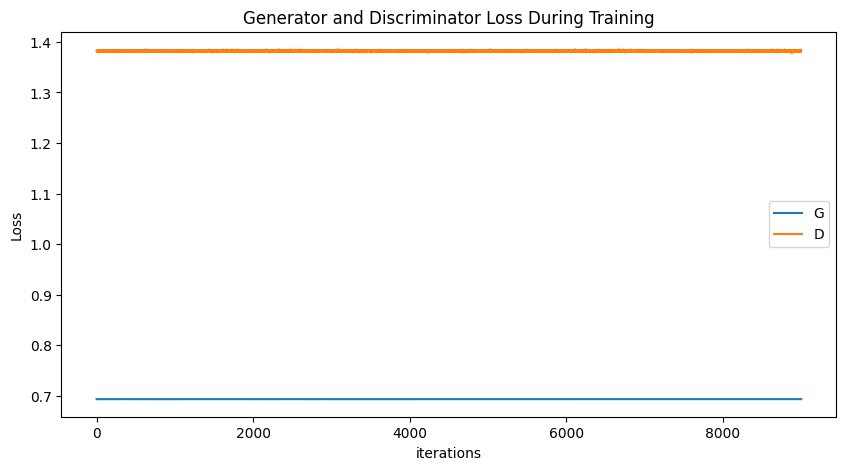

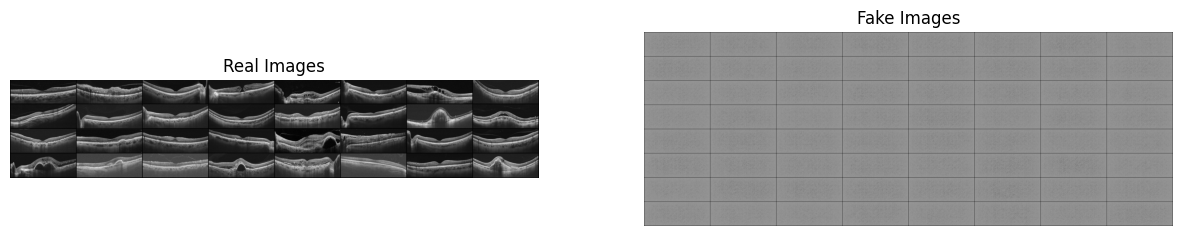

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()